In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
test=pd.read_excel(r"../data/chem_test.xlsx")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
gpr_nox=torch.load("../models/nox_seasonality",weights_only=False,map_location='cuda')

In [5]:
gpr_no2=torch.load("../models/no2_seasonality",weights_only=False,map_location='cuda')

In [6]:
test=test.loc[(test.corrected_week>0)&(test.corrected_week<52.5),:]

In [27]:
test

,Unnamed: 0.1,household,Unnamed: 0,maalnr,constrution_year,Area,floor_level,powerplant,road,motorway,...,fireplace,visit,no2,nox,formaldehyd,acetald,acetone,sample_time,corrected_week,scale
0,0,123,678,1,1946.011162,95.590656,0.987648,3.588932,22017.351254,1680.963528,...,0.319762,1,10.042529,22.753895,11.103315,5.108489,14.579316,71,9.130552,8.559958
2,2,395,1,2,1973.163229,100.076800,0.000000,58.412577,17596.108786,2717.951668,...,0.000000,2,6.422655,10.736846,18.104669,7.473889,6.021540,71,40.312658,8.977074
3,3,394,593,2,1974.130398,115.388499,0.000000,0.000000,24529.058945,2451.396731,...,0.000000,2,6.412073,2.635114,22.883348,7.947299,10.391725,72,42.190289,9.021339
4,4,394,650,1,1957.165618,85.489464,0.000000,87.399164,20847.968256,2448.566481,...,6.870260,1,7.566317,5.309327,15.521747,5.441382,12.699045,70,11.672683,8.385715
5,5,394,733,2,1969.125817,50.118358,0.990119,0.000000,18243.527388,645.770316,...,0.000000,2,6.181168,0.797949,18.390136,2.356710,0.000000,71,25.057175,8.796073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,167,398,427,2,1981.487175,110.245873,0.000000,129.170607,17462.584189,2294.703519,...,2.273455,2,5.787783,0.130493,20.448919,0.195881,1.141924,72,41.914400,9.010391
168,168,398,524,3,1931.195558,80.226949,0.000825,127.309361,21020.747307,2969.804750,...,0.000000,3,9.250498,5.782333,33.068377,0.798056,2.281345,72,39.749950,8.978866
169,169,398,732,2,1970.320301,94.187234,0.000613,118.204290,17276.046587,2443.596326,...,5.756050,2,3.596870,0.000000,14.513980,1.210494,1.523234,71,24.801265,8.763985
170,170,398,773,3,1952.520569,120.022392,0.000000,110.985695,16441.638986,1739.807371,...,0.000000,3,3.833118,4.386033,24.070040,0.591740,4.865385,70,37.046205,9.063200


<Axes: >

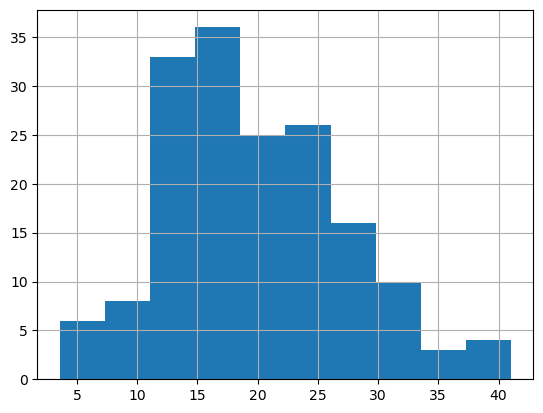

In [29]:
test.formaldehyd.hist()

In [8]:
def prediction(test,particle,model):
    gpr_points=model(torch.tensor(test.corrected_week.values).float().to(device))
    test["scale"]=gpr_points[0].cpu().detach().numpy()
    test_3=test.set_index("household").loc[test.groupby(test.household).maalnr.count()>=3,:]
    BC_1_raw=test_3.loc[test_3.maalnr==1,particle].groupby("household").first()
    BC_1_scale=test_3.loc[test_3.maalnr==1,"scale"].groupby("household").first()
    BC_2_raw=test_3.loc[test_3.maalnr==2,particle].groupby("household").first()
    BC_2_scale=test_3.loc[test_3.maalnr==2,"scale"].groupby("household").first()
    BC_3_scale=test_3.loc[test_3.maalnr==3,"scale"].groupby("household").first()
    BC_3_raw=test_3.loc[test_3.maalnr==3,particle].groupby("household").first()
    true_3=(BC_2_raw*BC_3_scale/BC_2_scale+BC_1_raw*BC_3_scale/BC_1_scale)/2
    true_1=(BC_2_raw*BC_1_scale/BC_2_scale+BC_3_raw*BC_1_scale/BC_3_scale)/2
    true_2=(BC_1_raw*BC_2_scale/BC_1_scale+BC_3_raw*BC_2_scale/BC_3_scale)/2
    prediction_matrix=pd.DataFrame([true_1,BC_1_raw,BC_1_scale,true_2,BC_2_raw,BC_2_scale,true_3,BC_3_raw,BC_3_scale],index=["predict_1","raw_1","scale_1","predict_2","raw_2","scale_2","predict_3","raw_3","scale_3"]).T
    return prediction_matrix

In [9]:
prediction_matrix_nox=prediction(test,"nox",gpr_nox).dropna()
prediction_matrix_no2=prediction(test,"no2",gpr_no2).dropna()

In [10]:
mean_3=prediction_matrix_nox.loc[:,["raw_1","raw_2"]].mean(axis=1)
mean_2=prediction_matrix_nox.loc[:,["raw_1","raw_3"]].mean(axis=1)
mean_1=prediction_matrix_nox.loc[:,["raw_2","raw_3"]].mean(axis=1)
mean_no2_3=prediction_matrix_no2.loc[:,["raw_1","raw_2"]].mean(axis=1)
mean_no2_2=prediction_matrix_no2.loc[:,["raw_1","raw_3"]].mean(axis=1)
mean_no2_1=prediction_matrix_no2.loc[:,["raw_2","raw_3"]].mean(axis=1)

In [11]:
nox_r2=r2_score(prediction_matrix_nox.raw_1,prediction_matrix_nox.predict_1),r2_score(prediction_matrix_nox.raw_2,prediction_matrix_nox.predict_2),r2_score(prediction_matrix_nox.raw_3,prediction_matrix_nox.predict_3)

In [12]:
no2_r2=r2_score(prediction_matrix_no2.raw_1,prediction_matrix_no2.predict_1),r2_score(prediction_matrix_no2.raw_2,prediction_matrix_no2.predict_2),r2_score(prediction_matrix_no2.raw_3,prediction_matrix_no2.predict_3)

In [13]:
no2_r2_mean=r2_score(mean_no2_1,prediction_matrix_no2.raw_1),r2_score(mean_no2_2,prediction_matrix_no2.raw_2),r2_score(mean_no2_3,prediction_matrix_no2.raw_3)

In [14]:
nox_r2_mean=r2_score(prediction_matrix_nox.raw_1,mean_1),r2_score(prediction_matrix_nox.raw_2,mean_2),r2_score(prediction_matrix_nox.raw_3,mean_3)

In [15]:
np.mean(nox_r2_mean),np.mean(nox_r2)

(-0.4456424260317012, -2.917850313082616)

In [16]:
np.mean(no2_r2_mean),np.mean(no2_r2)

(-5.950654258154477, -1.8644362279713373)

In [17]:
nox_r2_mean

(-0.3461837121316007, -0.5631559415134277, -0.42758762445007514)

In [18]:
no2_r2

(-0.6680419178722745, -3.2493771352005414, -1.6758896308411964)

In [19]:
no2_r2=r2_score(prediction_matrix_no2.raw_1,prediction_matrix_no2.predict_1),r2_score(prediction_matrix_no2.raw_2,prediction_matrix_no2.predict_2),r2_score(prediction_matrix_no2.raw_3,prediction_matrix_no2.predict_3)

In [20]:
no2_r2=r2_score(prediction_matrix_no2.raw_1,prediction_matrix_no2.predict_1),r2_score(prediction_matrix_no2.raw_2,prediction_matrix_no2.predict_2),r2_score(prediction_matrix_no2.raw_3,prediction_matrix_no2.predict_3)

In [21]:
np.mean(nox_r2),np.mean(no2_r2)

(-2.917850313082616, -1.8644362279713373)

In [22]:
np.mean([0.5758409768987418, 0.20088129937141996, 0.47396355329719086])

0.4168952765224509

In [23]:
prediction_matrix_no2.corr()

,predict_1,raw_1,scale_1,predict_2,raw_2,scale_2,predict_3,raw_3,scale_3
predict_1,1.000000,-0.215458,0.372352,0.099713,0.632434,-0.244857,-0.001029,0.766366,-0.180787
raw_1,-0.215458,1.000000,0.147607,0.867483,-0.185381,0.010268,0.935136,-0.174482,0.345164
scale_1,0.372352,0.147607,1.000000,0.108608,0.048303,-0.524695,0.115782,0.234266,0.220329
predict_2,0.099713,0.867483,0.108608,1.000000,-0.208951,0.212760,0.800855,0.304000,0.527336
raw_2,0.632434,-0.185381,0.048303,-0.208951,1.000000,-0.290021,0.166366,0.022428,-0.746525
scale_2,-0.244857,0.010268,-0.524695,0.212760,-0.290021,1.000000,-0.087200,0.105395,0.375769
predict_3,-0.001029,0.935136,0.115782,0.800855,0.166366,-0.087200,1.000000,-0.169577,0.078117
raw_3,0.766366,-0.174482,0.234266,0.304000,0.022428,0.105395,-0.169577,1.000000,0.351664
scale_3,-0.180787,0.345164,0.220329,0.527336,-0.746525,0.375769,0.078117,0.351664,1.000000


In [101]:
prediction_matrix_nox.corr()

,predict_1,raw_1,scale_1,predict_2,raw_2,scale_2,predict_3,raw_3,scale_3
predict_1,1.000000,0.589576,0.526829,0.083466,0.071326,-0.300363,0.671152,0.804646,0.306662
raw_1,0.589576,1.000000,0.500013,0.075557,-0.070042,-0.282069,0.846295,0.706794,0.349445
scale_1,0.526829,0.500013,1.000000,-0.376510,-0.357020,-0.709868,0.459632,0.519601,0.627283
predict_2,0.083466,0.075557,-0.376510,1.000000,0.500378,0.752163,-0.042992,-0.033858,-0.455345
raw_2,0.071326,-0.070042,-0.357020,0.500378,1.000000,0.612609,-0.032412,-0.160012,-0.403626
scale_2,-0.300363,-0.282069,-0.709868,0.752163,0.612609,1.000000,-0.378896,-0.408928,-0.666939
predict_3,0.671152,0.846295,0.459632,-0.042992,-0.032412,-0.378896,1.000000,0.841263,0.619915
raw_3,0.804646,0.706794,0.519601,-0.033858,-0.160012,-0.408928,0.841263,1.000000,0.604632
scale_3,0.306662,0.349445,0.627283,-0.455345,-0.403626,-0.666939,0.619915,0.604632,1.000000
